In [ ]:
!pip install cassandra-driver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 80.9 MB/s eta 0:00:00


In [ ]:
import json
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# Load credentials from JSON file
with open("/content/final_project-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

# Connect to Cassandra
auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cloud_config = {"secure_connect_bundle": "secure-connect-final-project.zip"}
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

# Set keyspace
session.set_keyspace('survive')

# Confirm connection
if session:
    print("Connected!")
else:
    print("Connection failed.")


Connected!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

In [ ]:
csv_path = "/content/Airline_Delay_Cause.csv"
data = pd.read_csv(csv_path)

In [ ]:
create_silver_table_query = """
CREATE TABLE IF NOT EXISTS silver_flight_delay (
    year INT,
    month INT,
    carrier TEXT,
    airport TEXT,
    arr_flights DECIMAL,
    arr_del15 DECIMAL,
    carrier_ct DECIMAL,
    weather_ct DECIMAL,
    nas_ct DECIMAL,
    security_ct DECIMAL,
    late_aircraft_ct DECIMAL,
    arr_cancelled DECIMAL,
    arr_diverted DECIMAL,
    PRIMARY KEY ((year, month, carrier), airport)
);
"""

In [ ]:
session.execute(create_silver_table_query)
print("Silver table created successfully.")

Silver table created successfully.


In [ ]:
from cassandra.concurrent import execute_concurrent_with_args

# Step 1: Fetch data from the airdata table
rows = session.execute("""
SELECT year, month, carrier, airport, arr_flights, arr_del15, carrier_ct, weather_ct, nas_ct, security_ct, late_aircraft_ct, arr_cancelled, arr_diverted
FROM airdata;
""")

data = []
for row in rows:
    data.append((
        row.year,
        row.month,
        row.carrier,
        row.airport,
        int(row.arr_flights) if row.arr_flights is not None else 0,
        float(row.arr_del15) if row.arr_del15 is not None else 0.0,
        float(row.carrier_ct) if row.carrier_ct is not None else 0.0,
        float(row.weather_ct) if row.weather_ct is not None else 0.0,
        float(row.nas_ct) if row.nas_ct is not None else 0.0,
        float(row.security_ct) if row.security_ct is not None else 0.0,
        float(row.late_aircraft_ct) if row.late_aircraft_ct is not None else 0.0,
        float(row.arr_cancelled) if row.arr_cancelled is not None else 0.0,
        float(row.arr_diverted) if row.arr_diverted is not None else 0.0
    ))

# Step 3: Use batch insertion for improved performance
query = """
INSERT INTO silver_flight_delay (
    year, month, carrier, airport, arr_flights, arr_del15, carrier_ct, weather_ct, nas_ct, security_ct, late_aircraft_ct, arr_cancelled, arr_diverted
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

# Batch size (adjust based on your environment's limits)
batch_size = 1000
batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

for batch in batches:
    execute_concurrent_with_args(session, query, batch)

print("Data inserted into Silver table successfully.")


Data inserted into Silver table successfully.


In [ ]:
rows = session.execute("SELECT COUNT(*) FROM silver_flight_delay;")
for row in rows:
    print(row)

Row(count=171666)


In [ ]:
session.execute("""
CREATE TABLE IF NOT EXISTS gold_total_delays_by_carrier (
    carrier TEXT PRIMARY KEY,
    total_delays DECIMAL
);
""")
print("Gold table for total delays by carrier created.")


Gold table for total delays by carrier created.


In [ ]:
session.execute("""
CREATE TABLE IF NOT EXISTS gold_monthly_delays (
    year_month TEXT PRIMARY KEY,
    total_delays DECIMAL
);
""")
print("Gold table for monthly total delays created.")


Gold table for monthly total delays created.


In [ ]:
session.execute("""
CREATE TABLE IF NOT EXISTS gold_top_airports (
    airport TEXT PRIMARY KEY,
    total_delays DECIMAL
);
""")
print("Gold table for top airports with most delays created.")


Gold table for top airports with most delays created.


In [ ]:
from cassandra.query import BatchStatement

# Fetch data from the silver_flight_delay table
rows = session.execute("SELECT carrier, arr_del15 FROM silver_flight_delay;")

# Aggregate data by carrier
from collections import defaultdict
carrier_delays = defaultdict(float)
for row in rows:
    carrier_delays[row.carrier] += float(row.arr_del15) if row.arr_del15 else 0.0

# Insert results into gold_total_delays_by_carrier
batch = BatchStatement()
for carrier, total_delays in carrier_delays.items():
    batch.add("""
    INSERT INTO gold_total_delays_by_carrier (carrier, total_delays)
    VALUES (%s, %s)
    """, (carrier, total_delays))
    if len(batch) >= 50:  # Execute in batches of 50
        session.execute(batch)
        batch = BatchStatement()
if len(batch) > 0:  # Insert remaining rows
    session.execute(batch)
print("Total delays by carrier inserted into gold_total_delays_by_carrier.")


Total delays by carrier inserted into gold_total_delays_by_carrier.


In [ ]:
rows = session.execute("SELECT year, month, arr_del15 FROM silver_flight_delay;")
monthly_delays = defaultdict(float)
for row in rows:
    year_month = f"{row.year}-{row.month}"
    monthly_delays[year_month] += float(row.arr_del15) if row.arr_del15 else 0.0

batch = BatchStatement()
for year_month, total_delays in monthly_delays.items():
    batch.add("""
    INSERT INTO gold_monthly_delays (year_month, total_delays)
    VALUES (%s, %s)
    """, (year_month, total_delays))
    if len(batch) >= 50:
        session.execute(batch)
        batch = BatchStatement()
if len(batch) > 0:
    session.execute(batch)
print("Monthly delays inserted into gold_monthly_delays.")

Monthly delays inserted into gold_monthly_delays.


In [ ]:
rows = session.execute("SELECT airport, arr_del15 FROM silver_flight_delay;")
airport_delays = defaultdict(float)
for row in rows:
    airport_delays[row.airport] += float(row.arr_del15) if row.arr_del15 else 0.0

top_airports = sorted(airport_delays.items(), key=lambda x: x[1], reverse=True)[:5]

batch = BatchStatement()
for airport, total_delays in top_airports:
    batch.add("""
    INSERT INTO gold_top_airports (airport, total_delays)
    VALUES (%s, %s)
    """, (airport, total_delays))
    if len(batch) >= 50:
        session.execute(batch)
        batch = BatchStatement()
if len(batch) > 0:
    session.execute(batch)
print("Top 5 airports inserted into gold_top_airports.")

Top 5 airports inserted into gold_top_airports.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch data from the gold_total_delays_by_carrier table
carrier_delays = pd.DataFrame(list(session.execute("SELECT * FROM gold_total_delays_by_carrier;")))

# Fetch data from the gold_monthly_delays table
monthly_delays = pd.DataFrame(list(session.execute("SELECT * FROM gold_monthly_delays;")))

# Fetch data from the gold_top_airports table
top_airports = pd.DataFrame(list(session.execute("SELECT * FROM gold_top_airports;")))


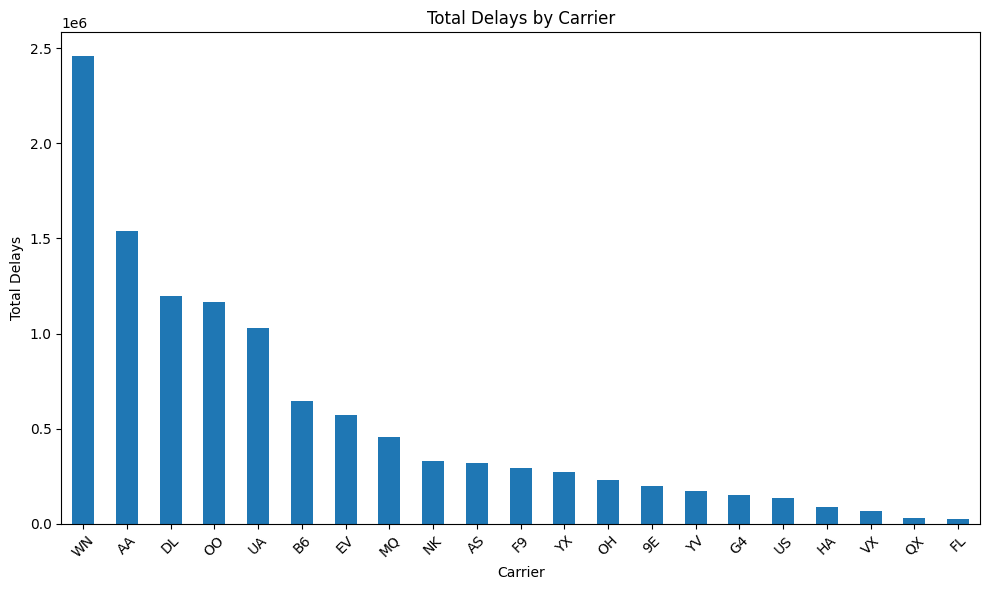

In [ ]:
# Ensure total_delays is numeric
carrier_delays['total_delays'] = pd.to_numeric(carrier_delays['total_delays'], errors='coerce')

# Drop rows with NaN values in total_delays (if any)
carrier_delays = carrier_delays.dropna(subset=['total_delays'])

# Ensure data is sorted by total_delays
carrier_delays = carrier_delays.sort_values(by='total_delays', ascending=False)

# Bar chart for total delays by carrier
carrier_delays.set_index('carrier')['total_delays'].plot(kind='bar', figsize=(10, 6))
plt.title('Total Delays by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Total Delays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


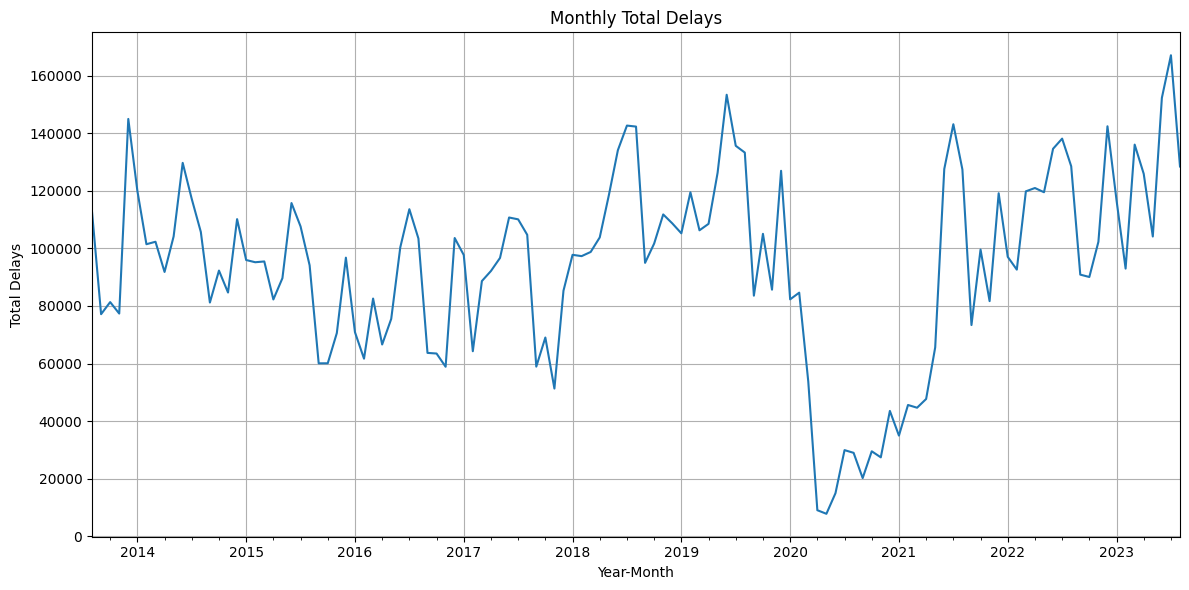

In [ ]:
monthly_delays['total_delays'] = pd.to_numeric(monthly_delays['total_delays'], errors='coerce')
monthly_delays = monthly_delays.dropna(subset=['total_delays'])
monthly_delays['year_month'] = pd.to_datetime(monthly_delays['year_month'], format='%Y-%m')
monthly_delays = monthly_delays.sort_values(by='year_month')

# Line chart for monthly delays
monthly_delays.set_index('year_month')['total_delays'].plot(figsize=(12, 6))
plt.title('Monthly Total Delays')
plt.xlabel('Year-Month')
plt.ylabel('Total Delays')
plt.grid()
plt.tight_layout()
plt.show()

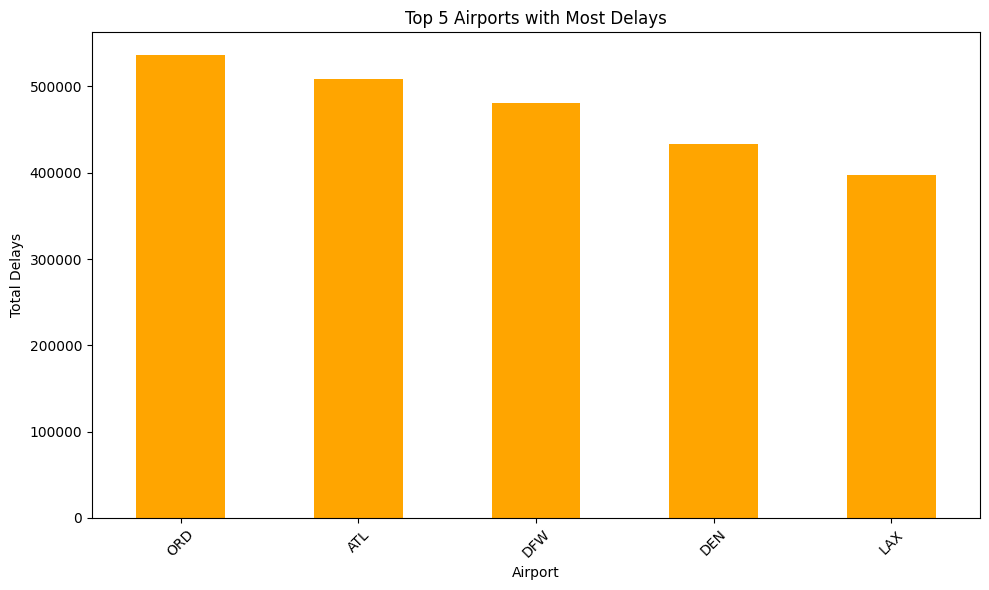

In [ ]:
top_airports['total_delays'] = pd.to_numeric(top_airports['total_delays'], errors='coerce')
top_airports = top_airports.dropna(subset=['total_delays'])
top_airports = top_airports.sort_values(by='total_delays', ascending=False)

# Bar chart for top airports with most delays
top_airports.set_index('airport')['total_delays'].plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Top 5 Airports with Most Delays')
plt.xlabel('Airport')
plt.ylabel('Total Delays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Features and target
X = data[features]
y = data['arr_del15']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Predictions and evaluation
y_pred = regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 5.483178805281047


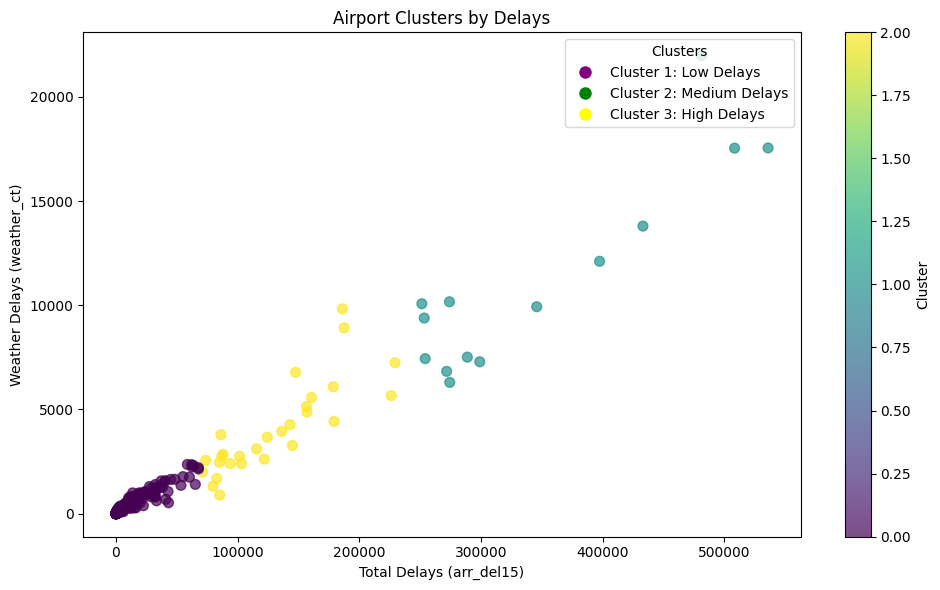

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Group data by airport and compute delay metrics
airport_data = data.groupby('airport').agg({
    'arr_del15': 'sum',
    'weather_ct': 'sum',
    'nas_ct': 'sum',
    'security_ct': 'sum'
}).reset_index()

# Features for clustering
X = airport_data[['arr_del15', 'weather_ct', 'nas_ct', 'security_ct']]

# Train K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)
airport_data['cluster'] = kmeans.fit_predict(X)

# Define cluster labels for legend
cluster_labels = {
    0: "Cluster 1: Low Delays",
    1: "Cluster 2: Medium Delays",
    2: "Cluster 3: High Delays"
}

# Map cluster labels for legend
airport_data['cluster_label'] = airport_data['cluster'].map(cluster_labels)

# Visualize clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(airport_data['arr_del15'], airport_data['weather_ct'],
                       c=airport_data['cluster'], cmap='viridis', s=50, alpha=0.7)

# Create legend for clusters
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=10)
                   for label, color in zip(cluster_labels.values(), ['purple', 'green', 'yellow'])]
plt.legend(handles=legend_elements, title="Clusters", loc="upper right")

# Plot details
plt.title("Airport Clusters by Delays")
plt.xlabel("Total Delays (arr_del15)")
plt.ylabel("Weather Delays (weather_ct)")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
# Map clusters to categories
cluster_labels = {
    0: "Low Delays",
    1: "Medium Delays",
    2: "High Delays"
}

# Add cluster labels to the airport data
airport_data['cluster_label'] = airport_data['cluster'].map(cluster_labels)

# Group airports by cluster
low_delay_airports = airport_data[airport_data['cluster_label'] == "Low Delays"]['airport'].tolist()
medium_delay_airports = airport_data[airport_data['cluster_label'] == "Medium Delays"]['airport'].tolist()
high_delay_airports = airport_data[airport_data['cluster_label'] == "High Delays"]['airport'].tolist()

# Display the lists
print("Airports with Low Delays:", low_delay_airports)
print("Airports with Medium Delays:", medium_delay_airports)
print("Airports with High Delays:", high_delay_airports)


Airports with Low Delays: ['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALO', 'ALS', 'ALW', 'AMA', 'ANC', 'APN', 'ART', 'ASE', 'ATW', 'ATY', 'AVL', 'AVP', 'AZA', 'AZO', 'BDL', 'BET', 'BFF', 'BFL', 'BFM', 'BGM', 'BGR', 'BHM', 'BIH', 'BIL', 'BIS', 'BJI', 'BKG', 'BLI', 'BLV', 'BMI', 'BOI', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BZN', 'CAE', 'CAK', 'CDB', 'CDC', 'CDV', 'CEC', 'CGI', 'CHA', 'CHO', 'CHS', 'CIC', 'CID', 'CIU', 'CKB', 'CLD', 'CLL', 'CMH', 'CMI', 'CMX', 'CNY', 'COD', 'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'CYS', 'DAB', 'DAY', 'DBQ', 'DDC', 'DEC', 'DHN', 'DIK', 'DLG', 'DLH', 'DRO', 'DRT', 'DSM', 'DVL', 'EAR', 'EAT', 'EAU', 'ECP', 'EFD', 'EGE', 'EKO', 'ELM', 'ELP', 'ENV', 'ERI', 'ESC', 'EUG', 'EVV', 'EWN', 'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLO', 'FNL', 'FNT', 'FOD', 'FOE', 'FSD', 'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV', 'GPT', 